# Objective

1. Explore the Crater dataset and check the distributions
2. Identify anomalies which can be used to detect the craters.

In [229]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import os
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset


from PIL import Image

In [230]:
source = os.path.join('..', 'data')

train_imgs_path = os.path.join(source, 'train/images')
train_lbls_path = os.path.join(source, 'train/labels')

test_imgs_path = os.path.join(source, 'test/images')
test_lbls_path = os.path.join(source, 'test/labels')

val_imgs_path = os.path.join(source, 'valid/images')
val_lbls_path = os.path.join(source, 'valid/labels')

In [231]:
def load_labels(label_path):
    label_files = os.listdir(label_path)
    data = []
    image_ids = set()
    for file in label_files:
        image_name, _ = os.path.splitext(file)
        image = image_name + ".jpg"
        # Already checked every picture is in jpg format.
        image_ids.add(image)
        
        with open(os.path.join(label_path, file), 'r') as f:
            lines = f.readlines()
            for line in lines:
                box_info = list(map(float, line.strip().split()))
                data.append([image, *box_info])

    df = pd.DataFrame(data, columns=['file', 
                                     'class_id', 
                                     'center_x',
                                     'center_y',
                                     'width',
                                     'height'
                                    ])
    return df, image_ids

train_labels, train_ids = load_labels(train_lbls_path)
val_labels, val_ids = load_labels(val_lbls_path)
test_labels, test_ids = load_labels(test_lbls_path)

In [232]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681 entries, 0 to 680
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   file      681 non-null    object 
 1   class_id  681 non-null    float64
 2   center_x  681 non-null    float64
 3   center_y  681 non-null    float64
 4   width     681 non-null    float64
 5   height    681 non-null    float64
dtypes: float64(5), object(1)
memory usage: 32.1+ KB


In [233]:
train_ids

{'011_png.rf.8ac312b4898f0106d10b76952a55d237.jpg',
 '012_png.rf.64da6ff4c62638096ee6e5bf689706bc.jpg',
 '013_png.rf.ee44d5aa33fd33a1ed62ae233180f505.jpg',
 '016_png.rf.1973f9540ae7f672257609a8e5721ab3.jpg',
 '017_png.rf.1504c0d3ecbf20af6bc5114ca197a0dd.jpg',
 '018_png.rf.2d4eed5581681fe83830e51634befdaf.jpg',
 '01_png.rf.4d2ebc5ed98ad1e69d667aadbce63d53.jpg',
 '020_png.rf.ce87f4889d7441275135633392f98ed7.jpg',
 '022_png.rf.00ae4e655a2774bada1e254641482935.jpg',
 '02_png.rf.610687947e4c92f77e6462104ec4b924.jpg',
 '03_png.rf.8f7b31e14642026833b7c0dcd1832862.jpg',
 '05_png.rf.844343145246e51e66a345419e1862bf.jpg',
 '06_png.rf.aaf8c66b9e4d5e99a3dc70bae7f62c07.jpg',
 '07_png.rf.3fba5e95c6827aa6c4132e70f2086555.jpg',
 '08_png.rf.944efdd0f108140b368d7ad2c37426df.jpg',
 '09_png.rf.3b796e77a5f0036af4cd4413fcbe07a5.jpg',
 'mars_crater--0-_jpg.rf.40c1dec94c66ab07d9da8c74fa58d6f8.jpg',
 'mars_crater--10-_jpg.rf.585b1aa305997e3055e86fcac72a806b.jpg',
 'mars_crater--101-_jpg.rf.8f4eb1c77ab9e64d2fd6

In [234]:
train_labels.head()

,file,class_id,center_x,center_y,width,height
0,mars_crater--110-_jpg.rf.593f6a3d9aed98e7a0895...,0.0,0.325781,0.416406,0.230469,0.354687
1,mars_crater--43-_jpg.rf.27ea7a65603205e491bc43...,0.0,0.384375,0.480469,0.054688,0.083594
2,mars_crater--43-_jpg.rf.27ea7a65603205e491bc43...,0.0,0.410938,0.087500,0.039844,0.057031
3,mars_crater--24-_jpg.rf.4614bb6844fda70ea8a3b4...,0.0,0.517969,0.499219,0.891406,0.998437
4,mars_crater--118-_jpg.rf.0a8b3fb0e1332e576901e...,0.0,0.675781,0.082031,0.040625,0.052344


# Load a sample image

In [235]:
## Open a sample image
image_name = os.listdir(train_imgs_path)[0]
print(image_name)
img = cv2.imread(os.path.join(train_imgs_path, image_name))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

# Find the corresponding file
rows = train_labels.loc[train_labels['file'] == image_name]
print("Shape:", img.shape)
img_width, img_height, _ = img.shape
for i, row in rows.iterrows():
    x, y, h, w = row['center_x'], row['center_y'], row['width'], row['height']
    
    x_min = int((x - w / 2) * img_width)
    x_max = int((x + w / 2) * img_width)
    y_min = int((y - h / 2) * img_height)
    y_max = int((y + h / 2) * img_height)
    
    color = (0, 255, 0)
    thickness = 2
    img = cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, thickness)

    label = f"Crater {i}"
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    font_thickness = 1
    text_color = (255, 255, 255)
    cv2.putText(img, label, (x_min, y_min - 10), font, font_scale, text_color, font_thickness)
    
fig = px.imshow(img, title="A sample image with craters")
fig.update_layout(coloraxis_showscale=False)
fig.show()

011_png.rf.8ac312b4898f0106d10b76952a55d237.jpg
Shape: (640, 640, 3)


# Bounding box area distribution

In [236]:
def plot_bb_dist(labels, title):
    labels['area'] = labels['width'] * labels['height']
    fig = px.histogram(labels, x='area', nbins=40, title=title)
    fig.show()

def plot_width_and_height_dist(labels):
    fig = px.histogram(labels, x='width', nbins=40, title='Width Distribution of the above data')
    fig2 = px.histogram(labels, x='height', nbins=40, title='Height Distribution of the above data')
    fig.show()
    fig2.show()
    

plot_bb_dist(train_labels, 'Train Bounding Box Area Distribution')
plot_width_and_height_dist(train_labels)
plot_bb_dist(val_labels, 'Validation Bounding Box Area Distribution')
plot_width_and_height_dist(val_labels)
plot_bb_dist(test_labels, 'Test Bounding Box Area Distribution')
plot_width_and_height_dist(test_labels)

# Aspect ratio distribution (width/height)

In [237]:
def plot_aspect_rt(labels):
    labels['ratio'] = labels['width'] / labels['height'] 
    fig = px.histogram(labels, x='ratio', nbins=40, title='Aspect Ratio Distribution')
    fig.show()

plot_aspect_rt(train_labels)
plot_aspect_rt(val_labels)
plot_aspect_rt(test_labels)

In [238]:
def extract_pixels(row: pd.Series, image_dir: str):
    """
    Extract pixel intensities from the bounding box (crater region) 
    and the background region of an image.

    Returns:
        tuple: Two flattened numpy arrays - (crater_pixels, background_pixels).
    """
    file_path = os.path.join(image_dir, row['file'])
    img = Image.open(file_path).convert("L")  # Convert to grayscale
    
    img_width, img_height = img.size
    
    x_min = int((row["center_x"] - row["width"] / 2) * img_width)
    x_max = int((row["center_x"] + row["width"] / 2) * img_width)
    y_min = int((row["center_y"] - row["height"] / 2) * img_height)
    y_max = int((row["center_y"] + row["height"] / 2) * img_height)
    
    # Ensure bounding box is within image dimensions
    x_min, x_max = max(0, x_min), min(img_width, x_max)
    y_min, y_max = max(0, y_min), min(img_height, y_max)
    
    img_array = np.array(img)
    
    crater_pixels = img_array[y_min: y_max, x_min:x_max].flatten()
    
    mask = np.ones((img_height, img_width), dtype=bool)
    mask[y_min:y_max, x_min:x_max] = False
    
    background_pixels = img_array[mask]
    
    return crater_pixels, background_pixels

In [239]:
train_labels['pixels'] = train_labels.apply(lambda row: extract_pixels(row, train_imgs_path), axis=1)

train_labels["crater_pixels"] = train_labels["pixels"].apply(lambda x: x[0])
train_labels["background_pixels"] = train_labels["pixels"].apply(lambda x: x[1])

all_crater_pixels = np.concatenate(train_labels["crater_pixels"].values)
all_background_pixels = np.concatenate(train_labels["background_pixels"].values)

In [240]:
# Precompute bins and frequencies
crater_hist, bin_edges = np.histogram(all_crater_pixels, bins=50, range=(0, 255))
background_hist, _ = np.histogram(all_background_pixels, bins=50, range=(0, 255))

print("Crater histogram:", crater_hist)
print("Background histogram:", background_hist)

Crater histogram: [101655  65917  71305  56961  50377  54481  61623  69593  81068  94585
 128094 119639 132179 146335 161861 178745 199309 219566 241703 257797
 321322 280507 289898 301660 300136 291310 280768 268670 257904 243070
 276479 210906 192509 175251 157425 142731 129238 116873 104847  95955
 105443  80339  73843  64792  54285  43061  33779  28209  24814  39877]
Background histogram: [ 3522415   442939   432342   478438   556168   690235   854775  1101236
  1380980  1796195  2949983  3215541  3958137  4773535  5651613  6474871
  7395590  8539367  9662950 10955109 15049363 14045052 15639188 17171704
 17983661 17426655 15712248 13560081 11632766  9849378  9896538  6772709
  5629878  4660749  3874241  3170157  2626587  2190271  1768968  1436682
  1420595   975951   803459   659952   537615   436965   369839   334326
   344337   646572]


In [241]:
fig = go.Figure()
fig.add_trace(go.Bar(x=bin_edges[:-1], y=crater_hist, name="Crater Region", width=5))
fig.add_trace(go.Bar(x=bin_edges[:-1], y=background_hist, name="Background Region", width=5))

fig.update_layout(
    title="Pixel Intensity Distribution (Binned)",
    xaxis_title="Pixel Intensity",
    yaxis_title="Frequency",
    barmode="overlay"
)
fig.show()

Pixel intensities distribution does not seem to be different between craters and non-craters. So it is possible to mask the craters and use the masked image to detect the craters.

## Sample non-crater image

One idea I came up with is to mask the craters and use the masked image for training autoencoders. However, I don't have a good idea on naturally masking the craters, but maybe there is a library or technology that can help with this. 

Instead, I decided to randomly sample a non-crater region in each image and resize it to 640x640. Maybe the masking is the better approach so that the model can learn the features of the craters, so I will leave this as an exerecise to my future self.

In [243]:

def sample_regions(image, bounding_boxes, crop_size, num_samples=5):
    img_height, img_width = image.shape
    cropped_regions = []  
    
    mask = np.zeros_like(image, dtype=np.uint8)
    for bbox in bounding_boxes:
        x_min, y_min, x_max, y_max = bbox
        mask[y_min:y_max, x_min:x_max] = 1  # Mark crater regions on the mask

    for _ in range(num_samples):
        valid_crop = False
        attempts = 0
        while not valid_crop and attempts < 10:  # Limit attempts to find a valid region
            # Randomly sample a top-left corner
            x_start = random.randint(0, img_width - crop_size)
            y_start = random.randint(0, img_height - crop_size)
            x_end = x_start + crop_size
            y_end = y_start + crop_size
            
            # Ensure the crop is within bounds and doesn't overlap with craters
            if x_end <= img_width and y_end <= img_height:
                crop_mask = mask[y_start:y_end, x_start:x_end]
                if np.sum(crop_mask) == 0:  # Ensure no crater pixels in the crop
                    cropped_regions.append(image[y_start:y_end, x_start:x_end])
                    valid_crop = True
            attempts += 1

    return cropped_regions

crop_size = 80
num_samples = 5
train_images = []

for image_name in train_ids:
    bounding_boxes = [] # (x_min, y_min, x_max, y_max) should be an element
    file_path = os.path.join(train_imgs_path, image_name)
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    img_height, img_width = image.shape
    rows = train_labels.loc[train_labels['file'] == image_name]
    for _, row in rows.iterrows():
        center_x_abs = int(row["center_x"] * img_width)
        center_y_abs = int(row["center_y"] * img_height)
        width_abs = int(row["width"] * img_width)
        height_abs = int(row["height"] * img_height)

        x_min = int(center_x_abs - width_abs / 2)
        x_max = int(center_x_abs + width_abs / 2)
        y_min = int(center_y_abs - height_abs / 2)
        y_max = int(center_y_abs + height_abs / 2)
        
        # Ensure bounding box is within image dimensions
        x_min, x_max = max(0, x_min), min(img_width, x_max)
        y_min, y_max = max(0, y_min), min(img_height, y_max)
        
        bounding_boxes.append((x_min, y_min, x_max, y_max))

    samples = sample_regions(image, bounding_boxes, crop_size=crop_size, num_samples=num_samples)
    train_images.extend(samples)

In [245]:
fig = px.imshow(train_images[3], title="A sample image with omitting craters")
print(train_images[3].shape)
fig.update_layout(coloraxis_showscale=False)
fig.show()

(80, 80)


# Autoencoder for crater detection

Using these masked images, we can train an autoencoder to detect the anomalies (craters).

In [246]:
# Define the dataset without craters
class MarsDataset(Dataset):
    def __init__(self, images):
        self.images = images
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = cv2.resize(image, (640, 640))
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0) / 255.0  # Normalize and add channel dim
        return image

In [247]:
class conv_autoencoder(nn.Module):
    def __init__(self):
        super(conv_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # b, 320, 320
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # 80, 80
            nn.ReLU(True),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), # 160, 160
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # 320, 320
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # 640, 640
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

(640, 640, 1)


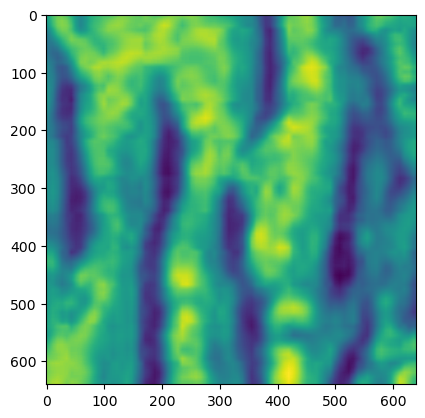

In [257]:
dataset = MarsDataset(train_images)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

image = next(iter(dataloader))
image1 = image.numpy().transpose(0, 2, 3, 1)[0, ..., :3]
print(image1.shape)
plt.imshow(image1)

In [ ]:
from torch.autograd import Variable
from tqdm import tqdm

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

model = conv_autoencoder().to(device)
criterion = nn.MSELoss()
params = [param for param in model.parameters() if param.requires_grad]
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

num_epochs = 10
for epoch in range(num_epochs):
    for image in tqdm(dataloader):
        image = Variable(image).to(device)
        output = model(image)
        loss = criterion(output, image)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("loss:", loss.item())

100%|██████████| 29/29 [00:06<00:00,  4.74it/s]


loss: 0.01856653206050396


100%|██████████| 29/29 [00:03<00:00,  8.98it/s]


loss: 0.0022282088175415993


100%|██████████| 29/29 [00:03<00:00,  9.12it/s]


loss: 0.001745992572978139


100%|██████████| 29/29 [00:03<00:00,  9.17it/s]


loss: 0.0012199048651382327


100%|██████████| 29/29 [00:03<00:00,  9.17it/s]


loss: 0.0005184048786759377


100%|██████████| 29/29 [00:03<00:00,  9.15it/s]


loss: 0.0007348028011620045


100%|██████████| 29/29 [00:03<00:00,  9.16it/s]


loss: 0.00046155721065588295


100%|██████████| 29/29 [00:03<00:00,  8.86it/s]


loss: 0.00032421492505818605


100%|██████████| 29/29 [00:03<00:00,  8.95it/s]


loss: 0.0002799699723254889


100%|██████████| 29/29 [00:03<00:00,  8.84it/s]

loss: 0.00025122807710431516


In [280]:
# Inference loop

model.eval()
reconstruction_errors = []

for image_name in val_ids:
    file_path = os.path.join(val_imgs_path, image_name)
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    input_image = torch.tensor(image, dtype=torch.float32).unsqueeze(0) / 255.0
    input_image = Variable(input_image).to(device)
    with torch.no_grad():
        reconstructed = model(input_image)
    error = torch.abs(input_image - reconstructed.squeeze()) * 255.0
    reconstruction_errors.append(error)

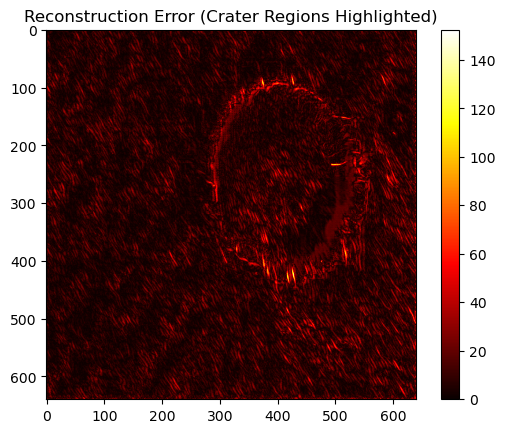

In [283]:
# Visualize Reconstruction Error
import matplotlib.pyplot as plt
plt.imshow(reconstruction_errors[0].cpu().detach().numpy().transpose(1, 2, 0), cmap="hot")
plt.title("Reconstruction Error (Crater Regions Highlighted)")
plt.colorbar()
plt.show()

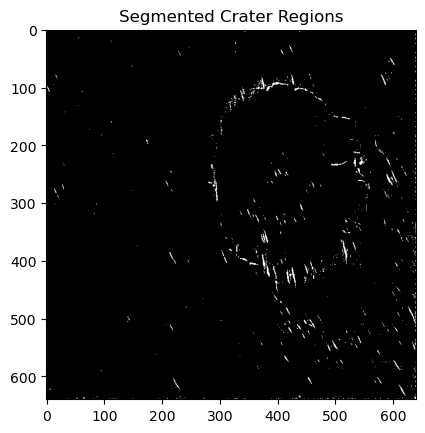

In [ ]:
# Threshold Reconstruction Error
threshold = np.percentile(np.concatenate([e.cpu().ravel() for e in reconstruction_errors]), 95)  # Top 5% error
segmented_images = [error > threshold for error in reconstruction_errors]

# Visualize Segmented Image
plt.imshow(segmented_images[0].cpu().numpy().transpose(1, 2, 0), cmap="gray")
plt.title("Segmented Crater Regions")
plt.show()

This is good. The outline of the craters are visible in the segmented images. This can be used to train a model to detect the craters.